In [1]:
import numpy as np
from scipy.stats import dirichlet
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gamma

def an_post(index, hm, xt, alpha):
    w0x = np.arange(1e-6, 1, 1/hm)
    x = tqdm.tqdm( w0x)
    w0y = []
    for w0 in x:
        w1x = np.arange(1e-6, 1-w0, 1/hm)
        w1y = []
        for w1 in w1x:
            w2 = 1-w0-w1
            if index == 0: w1y.append( np.exp( log_posterior(xt, np.array([w0, w1, w2]), alpha  ) ) ) 
            elif index == 1: w1y.append( np.exp( log_posterior(xt, np.array([w1, w0, w2]), alpha  ) ) ) 
            else: w1y.append( np.exp( log_posterior(xt, np.array([w2, w1, w0]), alpha  ) ) ) 
        w0y.append( np.trapz( np.array(w1y), w1x) )
    y = np.array(w0y)
    return w0x, y/np.trapz(y, w0x)

def generate_xt(n_pars, hm):
    xt = []
    for _ in range(hm):
        temp = np.linspace(10,1,n_pars) * np.random.uniform(0,1,n_pars)
        xt.append(temp/np.sum(temp))
    return np.array(xt)

def loglikelihood(xt, omega):
    return np.sum( np.log( np.array( [ np.sum(xt[i]*omega) for i in range(len(xt)) ] ) ) )

def log_posterior(xt, omega, alpha):
    return loglikelihood(xt, omega) + dirichlet.logpdf(omega, alpha = alpha)

def sampling(n, xt, alpha, alpha_prop):
    accepted = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        omega_new = np.hstack( dirichlet.rvs(alpha = alpha_prop, size = 1) )
        if log_rnd[i] <= log_acceptance_diri(xt, alpha, alpha_prop, omega, omega_new):
            omega = omega_new
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def sampling2(n, xt, alpha, eps, each):
    accepted = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    x = np.ones(len(alpha)) * len(alpha)
    omega = x/np.sum(x)
    alp = 1/eps**2
    scale = x*eps**2
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        x_pr = gamma.rvs(alp, scale = scale)
        omega_pr = x_pr/np.sum(x_pr)
        if i % each == 0: print(x_pr)
        if log_rnd[i] <= log_acceptance(xt, alpha, x, x_pr, omega, omega_pr, alp, eps, scale):
            omega = omega_pr
            x = x_pr
            scale = x_pr*eps**2
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def log_acceptance_diri(xt, alpha, alpha_prop, omega, omega_pr):
    return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) + dirichlet.logpdf(omega_pr, alpha = alpha_prop) - dirichlet.logpdf(omega, alpha = alpha_prop)

def log_acceptance(xt, alpha, x, x_pr, omega, omega_pr, alp, eps, scale):
            scale_reverse = x_pr*eps**2
            return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) + log_jacobian(x_pr) - log_jacobian(x) + norm.logpdf(np.sum(x_pr), loc = 0, scale = 1) - norm.logpdf(np.sum(x), loc = 0, scale = 1) - np.sum( gamma.logpdf(x_pr, a = alp, scale=scale) ) + np.sum( gamma.logpdf(x, a = alp, scale=scale_reverse) )

def log_jacobian(x):
    return -(len(x)) * np.log(np.sum(x))



In [2]:
def w1_post(w1arr, alpha, xt):
    a1,a2,a3 = alpha
    x1,y1,z1 = xt[0]
    x2,y2,z2 = xt[1]
    x3,y3,z3 = xt[2]
    y = []
    for w1 in w1arr:
        y.append( ((1-w1)**(-1+a2+a3)*w1**(-1+a1)*(-a2*(1+a2)*(2+a2)*(-1+w1)**3*y1*y2*y3+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y2*y3*(x1-z1)+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y2*y3*z1+a2*(1+a2)*(2+a2)*(-1+w1)**3*y2*y3*z1+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y1*y3*(x2-z2)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*y3*(x1-z1)*(x2-z2)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y3*z1*(x2-z2)-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y3*z1*(x2-z2)+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y1*y3*z2+a2*(1+a2)*(2+a2)*(-1+w1)**3*y1*y3*z2-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y3*(x1-z1)*z2-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y3*(x1-z1)*z2-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*y3*z1*z2-2*a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y3*z1*z2-a2*(1+a2)*(2+a2)*(-1+w1)**3*y3*z1*z2+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y1*y2*(x3-z3)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*y2*(x1-z1)*(x3-z3)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y2*z1*(x3-z3)-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y2*z1*(x3-z3)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*y1*(x2-z2)*(x3-z3)+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1**3*(x1-z1)*(x2-z2)*(x3-z3)+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1**2*z1*(x2-z2)*(x3-z3)+a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*z1*(x2-z2)*(x3-z3)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y1*z2*(x3-z3)-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y1*z2*(x3-z3)+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1**2*(x1-z1)*z2*(x3-z3)+a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*(x1-z1)*z2*(x3-z3)+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1*z1*z2*(x3-z3)+2*a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*z1*z2*(x3-z3)+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*z1*z2*(x3-z3)+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y1*y2*z3+a2*(1+a2)*(2+a2)*(-1+w1)**3*y1*y2*z3-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y2*(x1-z1)*z3-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y2*(x1-z1)*z3-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*y2*z1*z3-2*a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y2*z1*z3-a2*(1+a2)*(2+a2)*(-1+w1)**3*y2*z1*z3-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y1*(x2-z2)*z3-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y1*(x2-z2)*z3+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1**2*(x1-z1)*(x2-z2)*z3+a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*(x1-z1)*(x2-z2)*z3+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1*z1*(x2-z2)*z3+2*a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*z1*(x2-z2)*z3+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*z1*(x2-z2)*z3-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*y1*z2*z3-2*a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y1*z2*z3-a2*(1+a2)*(2+a2)*(-1+w1)**3*y1*z2*z3+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1*(x1-z1)*z2*z3+2*a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*(x1-z1)*z2*z3+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*(x1-z1)*z2*z3+(a2+a3)*(1+a2+a3)*(2+a2+a3)*z1*z2*z3+3*a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*z1*z2*z3+3*a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*z1*z2*z3+a2*(1+a2)*(2+a2)*(-1+w1)**3*z1*z2*z3))/((a2+a3)*(1+a2+a3)*(2+a2+a3)) )
    y = np.array(y)
    return y/np.trapz(y,w1arr)

def w2_post(w2arr, alpha, xt):
    a1,a2,a3 = alpha
    x1,y1,z1 = xt[0]
    x2,y2,z2 = xt[1]
    x3,y3,z3 = xt[2]
    y = []
    for w2 in w2arr:
        y.append( ((1-w2)**(-1+a1+a3)*w2**(-1+a2)*(-a1*(1+a1)*(2+a1)*(-1+w2)**3*x1*x2*x3+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x2*x3*(y1-z1)+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x2*x3*z1+a1*(1+a1)*(2+a1)*(-1+w2)**3*x2*x3*z1+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x1*x3*(y2-z2)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*x3*(y1-z1)*(y2-z2)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x3*z1*(y2-z2)-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x3*z1*(y2-z2)+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x1*x3*z2+a1*(1+a1)*(2+a1)*(-1+w2)**3*x1*x3*z2-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x3*(y1-z1)*z2-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x3*(y1-z1)*z2-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*x3*z1*z2-2*a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x3*z1*z2-a1*(1+a1)*(2+a1)*(-1+w2)**3*x3*z1*z2+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x1*x2*(y3-z3)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*x2*(y1-z1)*(y3-z3)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x2*z1*(y3-z3)-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x2*z1*(y3-z3)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*x1*(y2-z2)*(y3-z3)+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2**3*(y1-z1)*(y2-z2)*(y3-z3)+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2**2*z1*(y2-z2)*(y3-z3)+a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*z1*(y2-z2)*(y3-z3)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x1*z2*(y3-z3)-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x1*z2*(y3-z3)+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2**2*(y1-z1)*z2*(y3-z3)+a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*(y1-z1)*z2*(y3-z3)+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2*z1*z2*(y3-z3)+2*a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*z1*z2*(y3-z3)+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*z1*z2*(y3-z3)+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x1*x2*z3+a1*(1+a1)*(2+a1)*(-1+w2)**3*x1*x2*z3-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x2*(y1-z1)*z3-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x2*(y1-z1)*z3-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*x2*z1*z3-2*a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x2*z1*z3-a1*(1+a1)*(2+a1)*(-1+w2)**3*x2*z1*z3-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x1*(y2-z2)*z3-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x1*(y2-z2)*z3+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2**2*(y1-z1)*(y2-z2)*z3+a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*(y1-z1)*(y2-z2)*z3+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2*z1*(y2-z2)*z3+2*a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*z1*(y2-z2)*z3+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*z1*(y2-z2)*z3-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*x1*z2*z3-2*a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x1*z2*z3-a1*(1+a1)*(2+a1)*(-1+w2)**3*x1*z2*z3+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2*(y1-z1)*z2*z3+2*a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*(y1-z1)*z2*z3+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*(y1-z1)*z2*z3+(a1+a3)*(1+a1+a3)*(2+a1+a3)*z1*z2*z3+3*a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*z1*z2*z3+3*a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*z1*z2*z3+a1*(1+a1)*(2+a1)*(-1+w2)**3*z1*z2*z3))/((a1+a3)*(1+a1+a3)*(2+a1+a3)) )
    y = np.array(y)
    return y/np.trapz(y,w2arr)

def w3_post(w3arr, alpha, xt):
    a1,a2,a3 = alpha
    x1,y1,z1 = xt[0]
    x2,y2,z2 = xt[1]
    x3,y3,z3 = xt[2]
    y = []
    for w3 in w3arr:
        y.append( -(((1-w3)**(-1+a1+a2)*w3**(-1+a3)*(a1**3*((-1+w3)*x1-w3*z1)*((-1+w3)*x2-w3*z2)*((-1+w3)*x3-w3*z3)+a2*(2+3*a2+a2**2)*((-1+w3)*y1-w3*z1)*((-1+w3)*y2-w3*z2)*((-1+w3)*y3-w3*z3)+a1**2*(-3*w3*z1*((-1+w3)*x2-w3*z2)*((-1+w3)*x3-w3*z3)+(-1+w3)*x1*(a2*(-1+w3)*x3*((-1+w3)*y2-w3*z2)+3*w3*z2*(x3-w3*x3+w3*z3)+(-1+w3)*x2*(3*(-1+w3)*x3+a2*(-1+w3)*y3-3*w3*z3-a2*w3*z3)+a2*w3*(y3*(z2-w3*z2)+(y2-w3*y2+2*w3*z2)*z3))+a2*((-1+w3)*x2*((-1+w3)*x3*((-1+w3)*y1-w3*z1)+w3*(y3*(z1-w3*z1)+(y1-w3*y1+2*w3*z1)*z3))-w3*((-1+w3)*x3*((-1+w3)*y2*z1+(-1+w3)*y1*z2-2*w3*z1*z2)+w3*(-((-1+w3)*y3*z1*z2)+y2*(z1-w3*z1)*z3+(y1-w3*y1+3*w3*z1)*z2*z3))))+a1*(-2*w3*z1*((-1+w3)*x2-w3*z2)*((-1+w3)*x3-w3*z3)+(-1+w3)*x1*(a2**2*((-1+w3)*y2-w3*z2)*((-1+w3)*y3-w3*z3)+2*w3*z2*(x3-w3*x3+w3*z3)+(-1+w3)*x2*(2*(-1+w3)*x3+a2*(-1+w3)*y3-2*w3*z3-a2*w3*z3)+a2*((-1+w3)*x3*((-1+w3)*y2-w3*z2)+(-1+w3)*y2*((-1+w3)*y3-2*w3*z3)+w3*z2*(-2*(-1+w3)*y3+3*w3*z3)))+a2*((-1+w3)*x3*((-1+w3)*y1*((-1+w3)*y2-2*w3*z2)+w3*z1*(-2*(-1+w3)*y2+3*w3*z2))+(-1+w3)*x2*((-1+w3)*x3*((-1+w3)*y1-w3*z1)+(-1+w3)*y1*((-1+w3)*y3-2*w3*z3)+w3*z1*(-2*(-1+w3)*y3+3*w3*z3))-w3*((-1+w3)*y2*((-1+w3)*y3*z1+(-1+w3)*y1*z3-3*w3*z1*z3)+z2*((-1+w3)*y1*((-1+w3)*y3-3*w3*z3)+3*w3*z1*(y3-w3*y3+2*w3*z3))))+a2**2*((-1+w3)*x3*((-1+w3)*y1-w3*z1)*((-1+w3)*y2-w3*z2)+(-1+w3)*x2*((-1+w3)*y1-w3*z1)*((-1+w3)*y3-w3*z3)-w3*((-1+w3)*y2*((-1+w3)*y3*z1+(-1+w3)*y1*z3-2*w3*z1*z3)+z2*((-1+w3)*y1*((-1+w3)*y3-2*w3*z3)+w3*z1*(-2*(-1+w3)*y3+3*w3*z3)))))))/((a1+a2)*(1+a1+a2)*(2+a1+a2))) )
    y = np.array(y)
    return y/np.trapz(y,w3arr)

In [5]:
n_pars = 3
hm = 3
xt = generate_xt(n_pars, hm)
print(xt)

[[0.74652664 0.14179773 0.11167564]
 [0.6930771  0.18015549 0.12676741]
 [0.62005    0.33448477 0.04546523]]


In [4]:
a = 0.5
alpha = np.ones(n_pars)*a
alpha_prop = np.ones(n_pars)

n = int(1e5)

samples = sampling(n, xt, alpha, alpha_prop)
eps = 1
each = int(1e4)
#samples2 = sampling2(n, xt, alpha, eps, each)

Acceptance rate 0.393002:   5%|▌         | 5173/100000 [00:02<00:53, 1762.89it/s]


KeyboardInterrupt: 

In [ ]:
anal_x = []
anal = []
for i in range(n_pars):
    x,y = an_post(i, 100, xt, alpha)
    anal_x.append(x)
    anal.append(y)


100%|██████████| 100/100 [00:00<00:00, 604.21it/s]


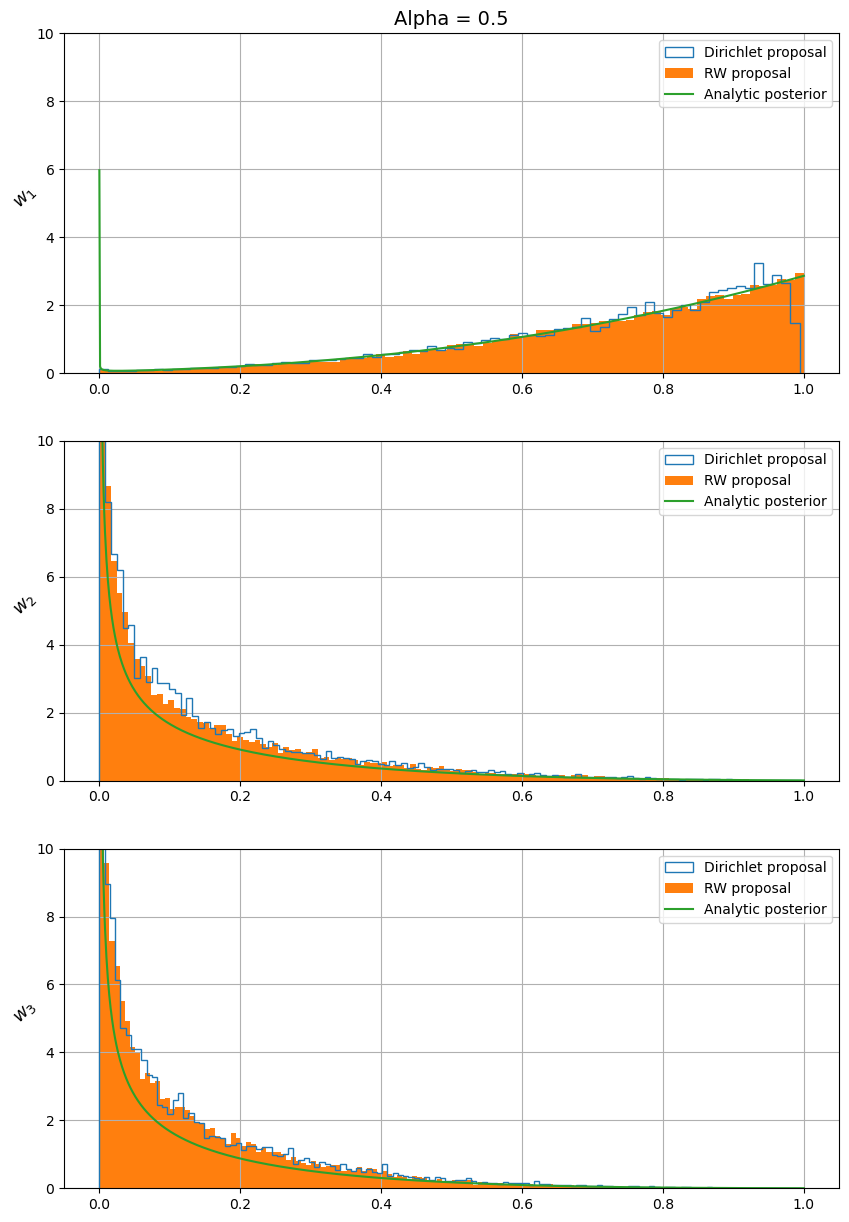

In [ ]:
fig, axs = plt.subplots( n_pars, figsize = [10,15] )
w = samples
w2 = samples2
x = np.arange(0, len(w[0]))
for i in range(n_pars):
    axs[i].hist(np.transpose(w)[i], bins = 'auto', histtype='step', density = True, label = 'Dirichlet proposal')
    axs[i].hist(np.transpose(w2)[i], bins = 'auto', density = True, label = 'RW proposal')
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    #axs[i].plot(anal_x[i], anal[i], label = 'Numerical posterior')
    if i == 0 : 
        xx = np.linspace(1e-6,1,1000)
        axs[i].plot(xx, w1_post(xx, alpha, xt), label = 'Analytic posterior')
    if i == 1 : 
        xx = np.linspace(1e-6,1,1000)
        axs[i].plot(xx, w2_post(xx, alpha, xt), label = 'Analytic posterior')
    if i == 2 : 
        xx = np.linspace(1e-6,1,1000)
        axs[i].plot(xx, w3_post(xx, alpha, xt), label = 'Analytic posterior')
    axs[i].grid()
    axs[i].legend()
    axs[i].set_ylim([0,10])
axs[0].set_title(f'Alpha = {alpha[0]}', size = 14)
plt.savefig('Alpha'+str(alpha[0])+'_second.png')
plt.show()
plt.close()

Acceptance rate 0.214953:   0%|          | 119/100000 [00:00<01:23, 1189.60it/s]

[0.91414856 1.19387717 1.53465172]


Acceptance rate 0.223060:  10%|█         | 10173/100000 [00:08<01:15, 1196.47it/s]

[0.02499024 0.00042798 0.00251972]


Acceptance rate 0.221887:  20%|██        | 20162/100000 [00:16<01:06, 1202.79it/s]

[0.0338542  0.01858021 0.00302787]


Acceptance rate 0.219620:  30%|███       | 30124/100000 [00:25<00:57, 1217.35it/s]

[2.71399460e-07 1.04114028e-06 9.88487266e-07]


Acceptance rate 0.220374:  40%|████      | 40204/100000 [00:33<00:50, 1191.97it/s]

[2.94925211e-05 6.91856335e-05 1.27236382e-03]


Acceptance rate 0.220881:  50%|█████     | 50087/100000 [00:42<00:41, 1215.06it/s]

[1.03651641e-16 7.78667276e-17 1.69082691e-16]


Acceptance rate 0.221386:  60%|██████    | 60112/100000 [00:50<00:33, 1174.19it/s]

[7.67845411e-32 1.62608490e-32 1.87619154e-31]


Acceptance rate 0.221638:  70%|███████   | 70093/100000 [00:59<00:25, 1175.45it/s]

[1.26416188e-38 4.27115712e-38 3.14206647e-39]


Acceptance rate 0.222419:  80%|████████  | 80106/100000 [01:07<00:16, 1199.47it/s]

[7.90863369e-34 3.71251868e-33 2.74041236e-34]


Acceptance rate 0.221600:  90%|█████████ | 90196/100000 [01:16<00:07, 1226.93it/s]

[6.68326718e-46 2.59450582e-47 1.86518170e-47]


100%|██████████| 100/100 [00:00<00:00, 596.41it/s]


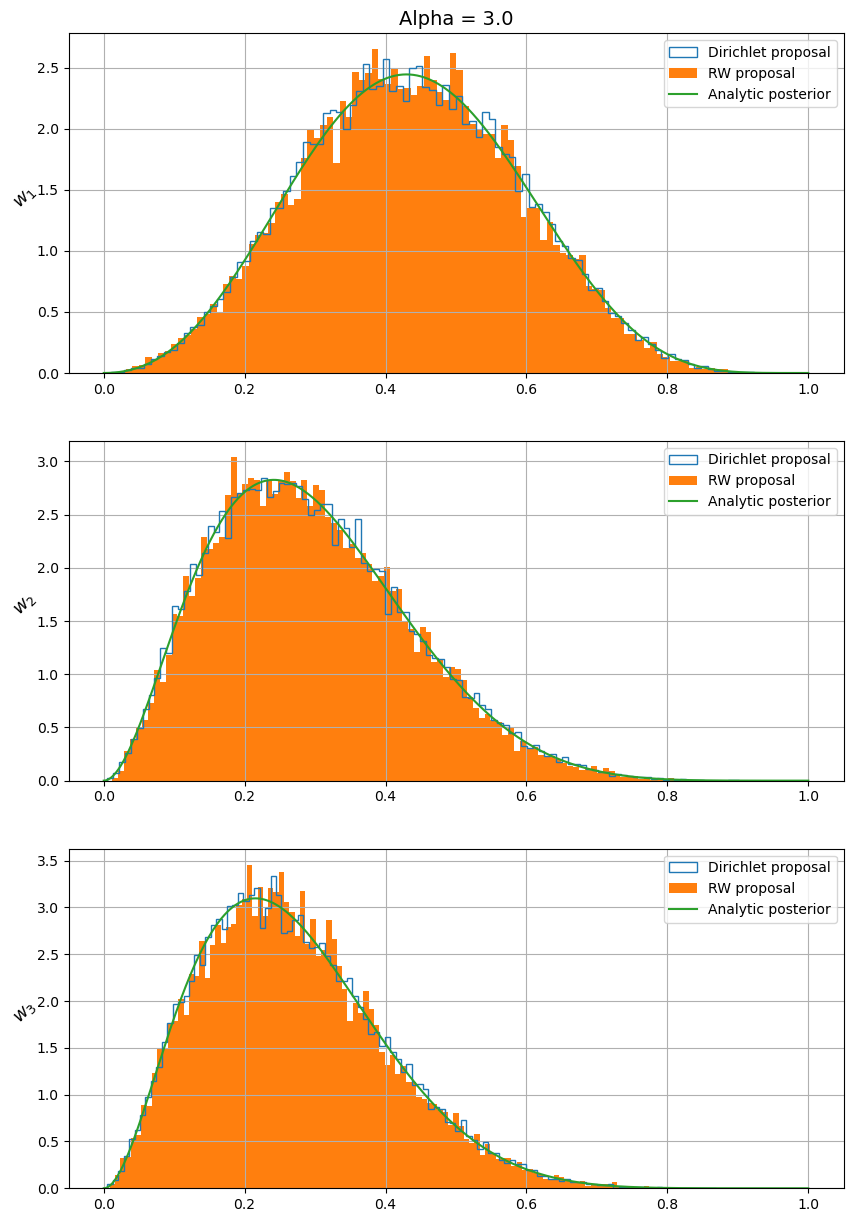

Acceptance rate 0.232877:   0%|          | 122/100000 [00:00<01:21, 1218.60it/s]

[0.12804638 0.95493791 0.1766773 ]


Acceptance rate 0.264835:  10%|█         | 10151/100000 [00:08<01:13, 1224.90it/s]

[1.19617650e-08 3.08667716e-10 9.91073112e-10]


Acceptance rate 0.264680:  20%|██        | 20118/100000 [00:16<01:07, 1186.63it/s]

[8.78243607e-18 6.33678220e-18 1.10171854e-17]


Acceptance rate 0.264368:  30%|███       | 30197/100000 [00:25<00:57, 1213.30it/s]

[5.06091848e-28 1.30917822e-28 2.64911140e-29]


Acceptance rate 0.263416:  40%|████      | 40160/100000 [00:33<00:46, 1295.95it/s]

[6.65891299e-42 4.88555838e-41 1.78214053e-42]


Acceptance rate 0.263997:  50%|█████     | 50118/100000 [00:40<00:38, 1281.42it/s]

[4.63993153e-32 4.78669691e-35 1.22518163e-34]


Acceptance rate 0.262574:  60%|██████    | 60154/100000 [00:48<00:30, 1295.80it/s]

[1.48563253e-27 7.36304139e-28 3.53144807e-28]


Acceptance rate 0.261903:  70%|███████   | 70220/100000 [00:56<00:23, 1268.46it/s]

[6.56293081e-33 9.70264429e-32 1.27756823e-34]


Acceptance rate 0.261542:  80%|████████  | 80203/100000 [01:04<00:15, 1285.64it/s]

[2.74774140e-45 1.33271972e-45 1.02930278e-45]


Acceptance rate 0.260689:  90%|█████████ | 90211/100000 [01:11<00:07, 1259.23it/s]

[3.61028129e-32 2.34460390e-32 6.54328390e-33]


100%|██████████| 100/100 [00:00<00:00, 621.33it/s]


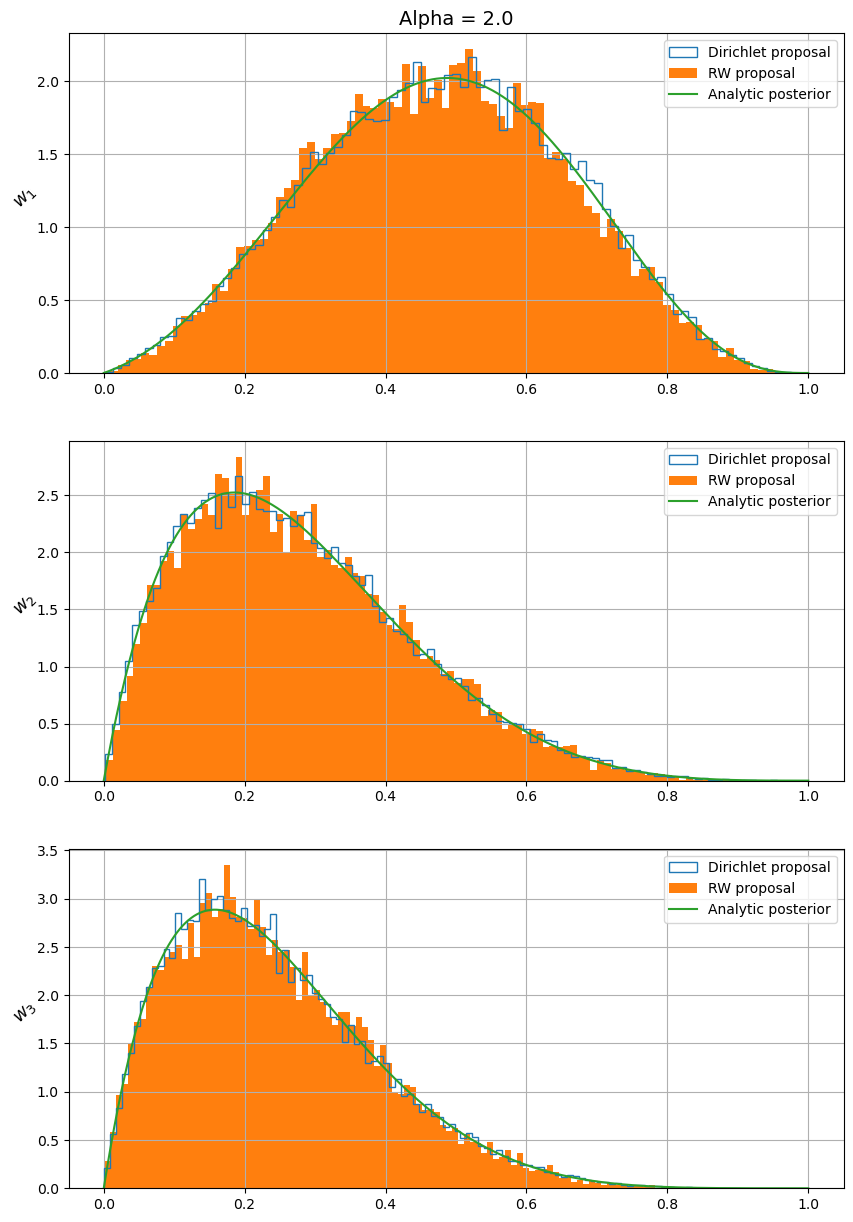

Acceptance rate 0.300847:   0%|          | 134/100000 [00:00<01:14, 1339.26it/s]

[4.90227435 2.79403109 8.76725873]


Acceptance rate 0.286944:  10%|█         | 10211/100000 [00:07<01:12, 1243.78it/s]

[2.87652842e-09 2.19046859e-09 5.00735689e-09]


Acceptance rate 0.276518:  20%|██        | 20167/100000 [00:15<01:01, 1295.30it/s]

[2.13094722e-12 8.35835891e-13 1.82064803e-14]


Acceptance rate 0.276017:  30%|███       | 30159/100000 [00:23<00:54, 1278.63it/s]

[2.49916833e-04 7.64647136e-05 1.06271574e-03]


Acceptance rate 0.274024:  40%|████      | 40132/100000 [00:31<00:46, 1299.81it/s]

[1.14461207e-04 1.76792895e-04 1.72494066e-06]


Acceptance rate 0.274519:  50%|█████     | 50134/100000 [00:39<00:38, 1282.73it/s]

[2.48023319e-05 1.71861700e-06 3.06094403e-06]


Acceptance rate 0.272982:  60%|██████    | 60115/100000 [00:46<00:29, 1343.44it/s]

[3.08279285e-07 2.29449833e-07 6.43788029e-07]


Acceptance rate 0.273029:  70%|███████   | 70227/100000 [00:54<00:23, 1289.93it/s]

[4.96094488e-17 3.45576322e-17 1.03653945e-16]


Acceptance rate 0.273518:  80%|████████  | 80186/100000 [01:02<00:15, 1293.29it/s]

[2.31619344e-18 1.71946681e-18 3.30984364e-19]


Acceptance rate 0.273379:  90%|█████████ | 90118/100000 [01:09<00:07, 1305.37it/s]

[4.27003783e-09 1.29055478e-09 3.41337156e-09]


100%|██████████| 100/100 [00:00<00:00, 613.47it/s]


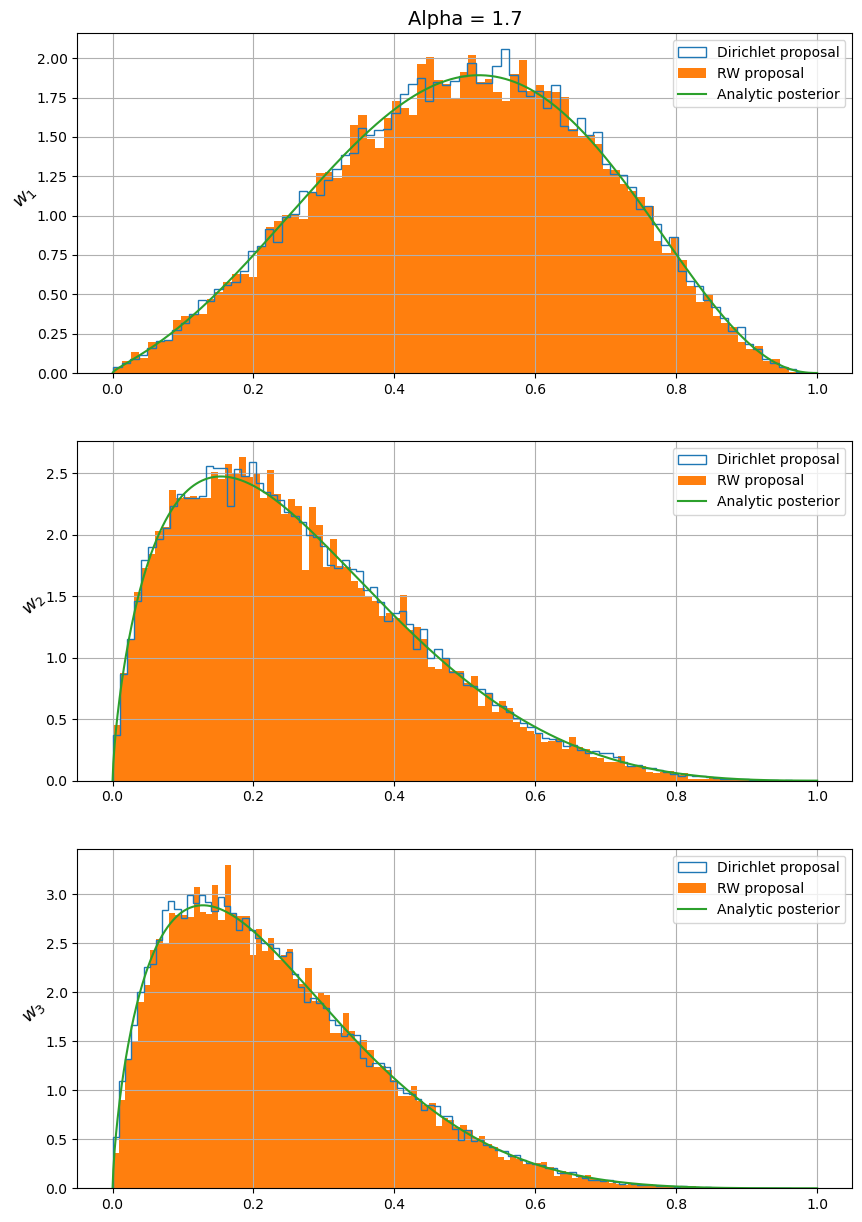

Acceptance rate 0.255319:   0%|          | 129/100000 [00:00<01:17, 1283.49it/s]

[6.90754208 0.23801953 0.19173668]


Acceptance rate 0.285170:  10%|█         | 10131/100000 [00:08<01:10, 1274.98it/s]

[0.11201135 0.00913356 0.00429184]


Acceptance rate 0.287990:  20%|██        | 20102/100000 [00:16<01:07, 1186.28it/s]

[7.11608651e-19 5.95451398e-18 2.16788908e-18]


Acceptance rate 0.287283:  30%|███       | 30215/100000 [00:24<00:56, 1246.07it/s]

[4.60632030e-23 2.61278875e-23 8.51078710e-23]


Acceptance rate 0.287852:  40%|████      | 40192/100000 [00:32<00:49, 1202.04it/s]

[1.74979208e-28 9.72531581e-29 6.66128038e-30]


Acceptance rate 0.287680:  50%|█████     | 50099/100000 [00:41<00:41, 1194.11it/s]

[5.95769383e-34 2.08706167e-34 1.04909154e-34]


Acceptance rate 0.287876:  60%|██████    | 60087/100000 [00:49<00:32, 1232.73it/s]

[9.05192846e-24 3.56416367e-23 2.59743442e-23]


Acceptance rate 0.288775:  70%|███████   | 70147/100000 [00:57<00:24, 1200.78it/s]

[1.70654968e-18 3.70487009e-18 4.18362287e-19]


Acceptance rate 0.288474:  80%|████████  | 80115/100000 [01:05<00:16, 1197.43it/s]

[1.75433993e-13 2.75854640e-13 4.72277004e-14]


Acceptance rate 0.288009:  90%|█████████ | 90202/100000 [01:13<00:07, 1293.66it/s]

[0.00215491 0.00560462 0.00204409]


100%|██████████| 100/100 [00:00<00:00, 619.11it/s]


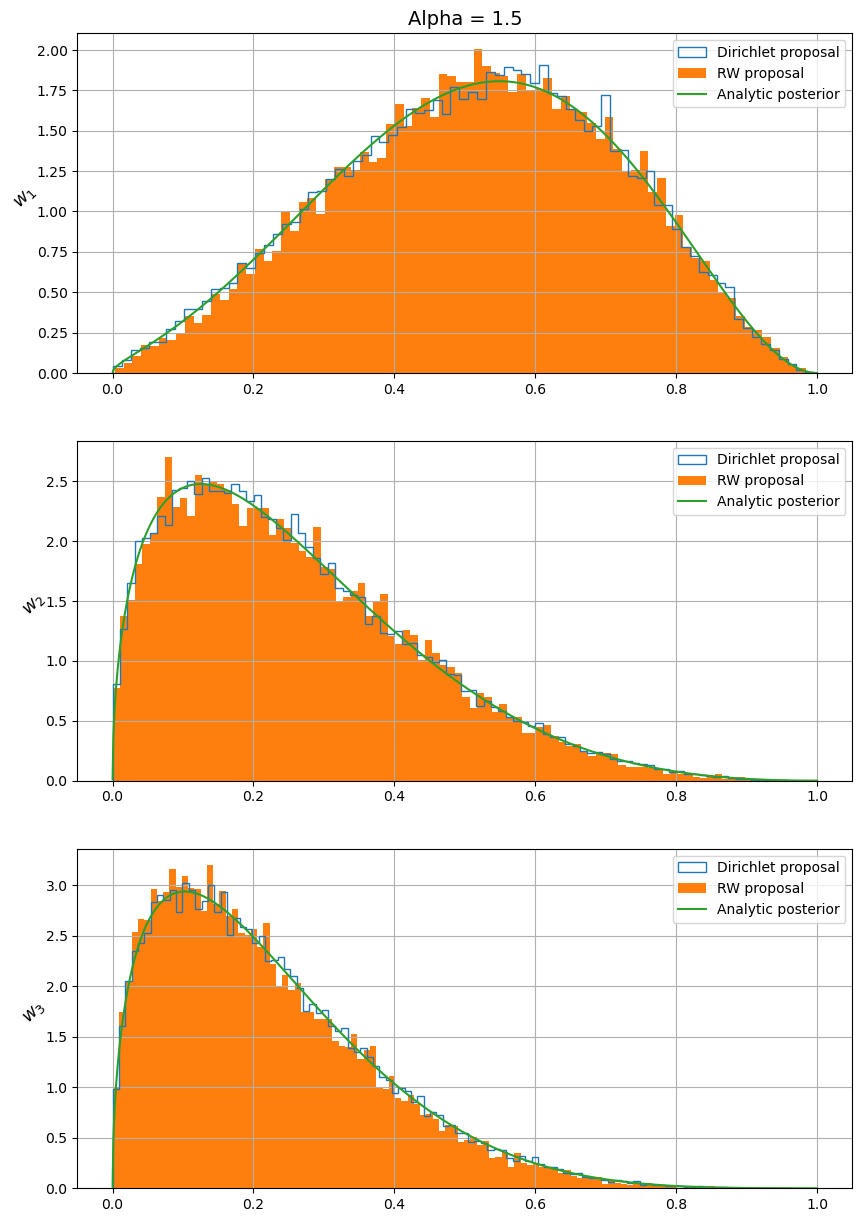

Acceptance rate 0.309013:   0%|          | 137/100000 [00:00<01:12, 1368.88it/s]

[9.07154418 2.38340207 2.61616301]


Acceptance rate 0.289595:  10%|█         | 10102/100000 [00:07<01:07, 1340.39it/s]

[2.49823579e-11 1.96676095e-11 1.48116762e-09]


Acceptance rate 0.291117:  20%|██        | 20169/100000 [00:15<01:00, 1309.35it/s]

[9.76033935e-11 6.15698440e-11 1.50978567e-11]


Acceptance rate 0.290899:  30%|███       | 30113/100000 [00:23<00:55, 1252.79it/s]

[6.62208164e-05 1.57435470e-05 1.06025290e-04]


Acceptance rate 0.289916:  40%|████      | 40145/100000 [00:31<00:47, 1267.57it/s]

[5.34380314e-16 1.12947705e-15 1.95121225e-16]


Acceptance rate 0.290990:  50%|█████     | 50137/100000 [00:38<00:38, 1292.91it/s]

[2.70063268e-22 2.30867697e-23 8.84038411e-24]


Acceptance rate 0.291984:  60%|██████    | 60179/100000 [00:46<00:30, 1294.10it/s]

[3.40473377e-20 1.54057887e-21 1.09660521e-20]


Acceptance rate 0.291749:  70%|███████   | 70238/100000 [00:54<00:23, 1275.36it/s]

[5.25305044e-17 7.61098936e-18 2.06920760e-18]


Acceptance rate 0.292721:  80%|████████  | 80157/100000 [01:02<00:15, 1280.28it/s]

[1.57817883e-12 1.10780845e-13 1.52431751e-14]


Acceptance rate 0.292868:  90%|█████████ | 90115/100000 [01:10<00:07, 1240.34it/s]

[3.76275721e-17 1.89248379e-17 1.47576724e-17]


100%|██████████| 100/100 [00:00<00:00, 621.66it/s]


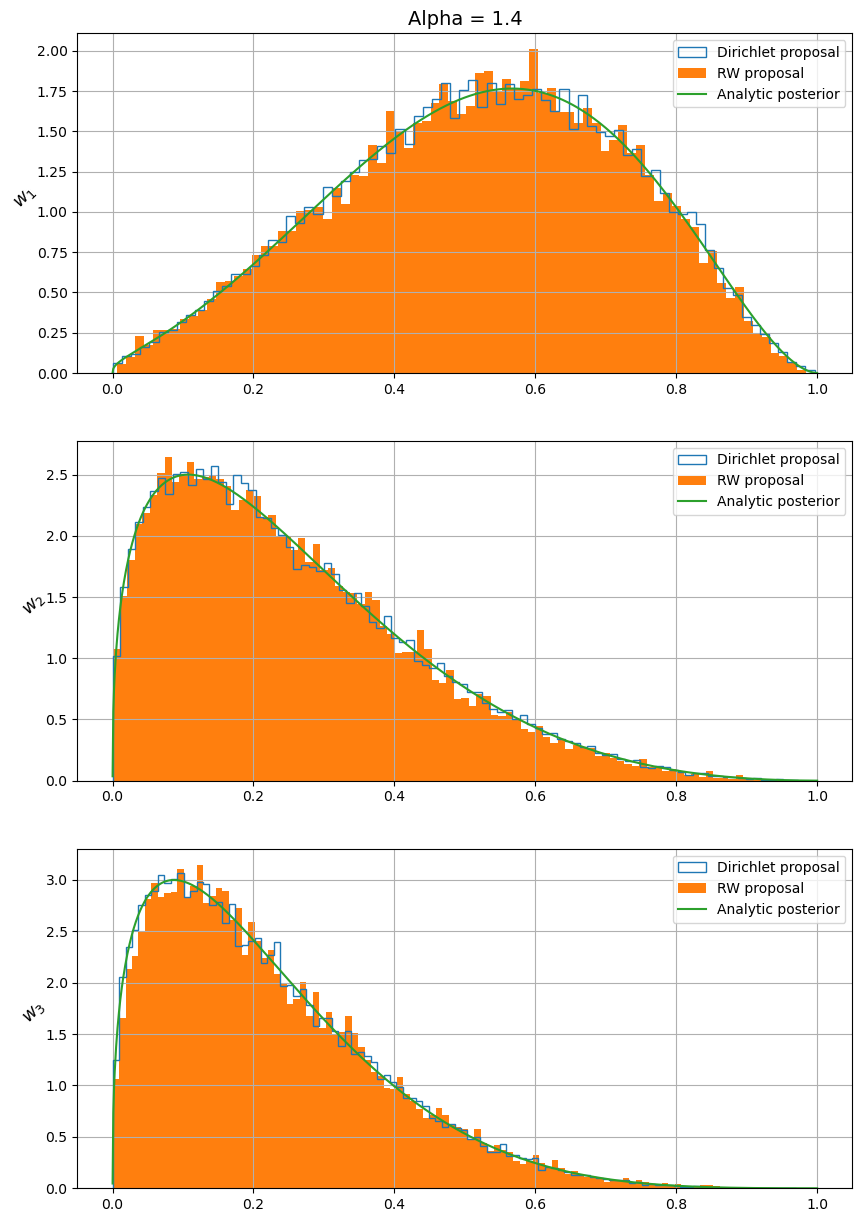

Acceptance rate 0.248963:   0%|          | 129/100000 [00:00<01:18, 1278.64it/s]

[1.01829373 1.51731548 3.8495266 ]


Acceptance rate 0.294612:  10%|█         | 10131/100000 [00:08<01:09, 1293.85it/s]

[0.00054012 0.00399525 0.00173617]


Acceptance rate 0.297470:  20%|██        | 20208/100000 [00:15<01:00, 1321.72it/s]

[3.92754238e-04 2.76399899e-05 1.81832556e-04]


Acceptance rate 0.295539:  30%|███       | 30204/100000 [00:23<00:55, 1246.43it/s]

[5.14456446e-13 1.37833119e-11 2.00814799e-12]


Acceptance rate 0.297731:  40%|████      | 40155/100000 [00:31<00:46, 1287.97it/s]

[6.76602828e-13 1.12622475e-14 3.11935696e-13]


Acceptance rate 0.297939:  50%|█████     | 50112/100000 [00:39<00:39, 1277.41it/s]

[2.23658048e-15 3.71586358e-17 1.05824725e-15]


Acceptance rate 0.299452:  60%|██████    | 60190/100000 [00:46<00:30, 1305.18it/s]

[0.0021429  0.00130544 0.00347841]


Acceptance rate 0.300172:  70%|███████   | 70180/100000 [00:54<00:23, 1271.00it/s]

[3.00608824e-20 8.68834642e-21 2.61618021e-20]


Acceptance rate 0.299892:  80%|████████  | 80104/100000 [01:02<00:15, 1268.30it/s]

[1.77184557e-37 6.03809882e-37 5.78888040e-37]


Acceptance rate 0.300518:  90%|█████████ | 90106/100000 [01:10<00:07, 1260.44it/s]

[1.30738431e-39 5.32892355e-40 1.14646166e-39]


100%|██████████| 100/100 [00:00<00:00, 611.78it/s]


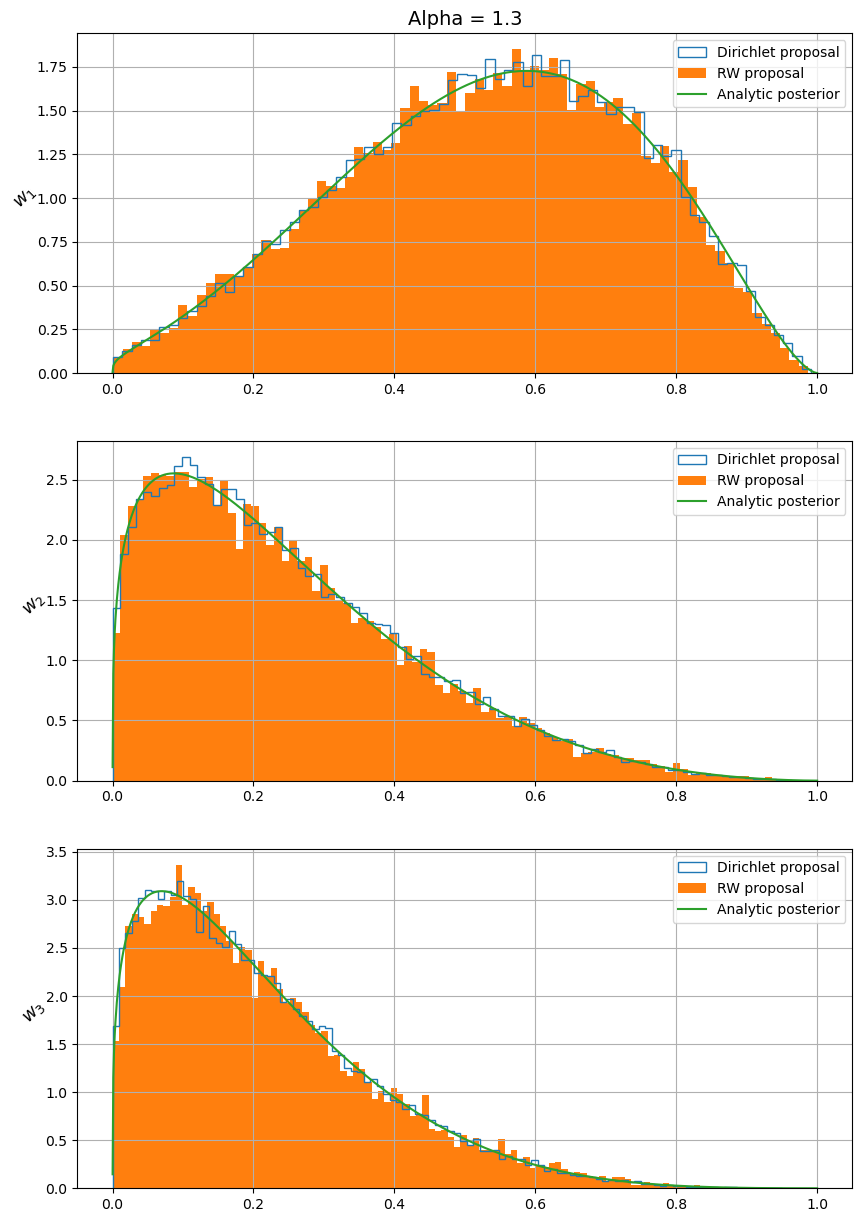

Acceptance rate 0.327731:   0%|          | 137/100000 [00:00<01:13, 1363.12it/s]

[3.41326947 0.31691058 0.47973188]


Acceptance rate 0.311022:  10%|█         | 10197/100000 [00:07<01:07, 1338.45it/s]

[6.15856018e-16 1.33844543e-17 9.67272013e-17]


Acceptance rate 0.307152:  20%|██        | 20222/100000 [00:15<01:01, 1299.83it/s]

[1.06692263e-17 5.66735965e-21 7.20792384e-19]


Acceptance rate 0.307199:  30%|███       | 30140/100000 [00:23<00:55, 1268.87it/s]

[1.51659578e-20 3.01995731e-20 1.40094896e-19]


Acceptance rate 0.306058:  40%|████      | 40115/100000 [00:31<00:46, 1297.41it/s]

[0.25140197 0.26378834 0.0052947 ]


Acceptance rate 0.307504:  50%|█████     | 50168/100000 [00:38<00:37, 1317.51it/s]

[1.98470168e-08 2.97301740e-09 4.70585867e-09]


Acceptance rate 0.308055:  60%|██████    | 60128/100000 [00:46<00:30, 1294.98it/s]

[5.52583345e-05 6.22423633e-05 5.89343099e-05]


Acceptance rate 0.307976:  70%|███████   | 70156/100000 [00:54<00:23, 1271.66it/s]

[9.13962973e-11 1.02630007e-10 3.16326103e-10]


Acceptance rate 0.308633:  80%|████████  | 80139/100000 [01:02<00:15, 1299.98it/s]

[2.94323397e-25 5.54739518e-26 1.72552426e-25]


Acceptance rate 0.309053:  90%|█████████ | 90209/100000 [01:10<00:07, 1258.44it/s]

[2.72096796e-34 2.34465385e-35 5.68502229e-36]


100%|██████████| 100/100 [00:00<00:00, 607.84it/s]


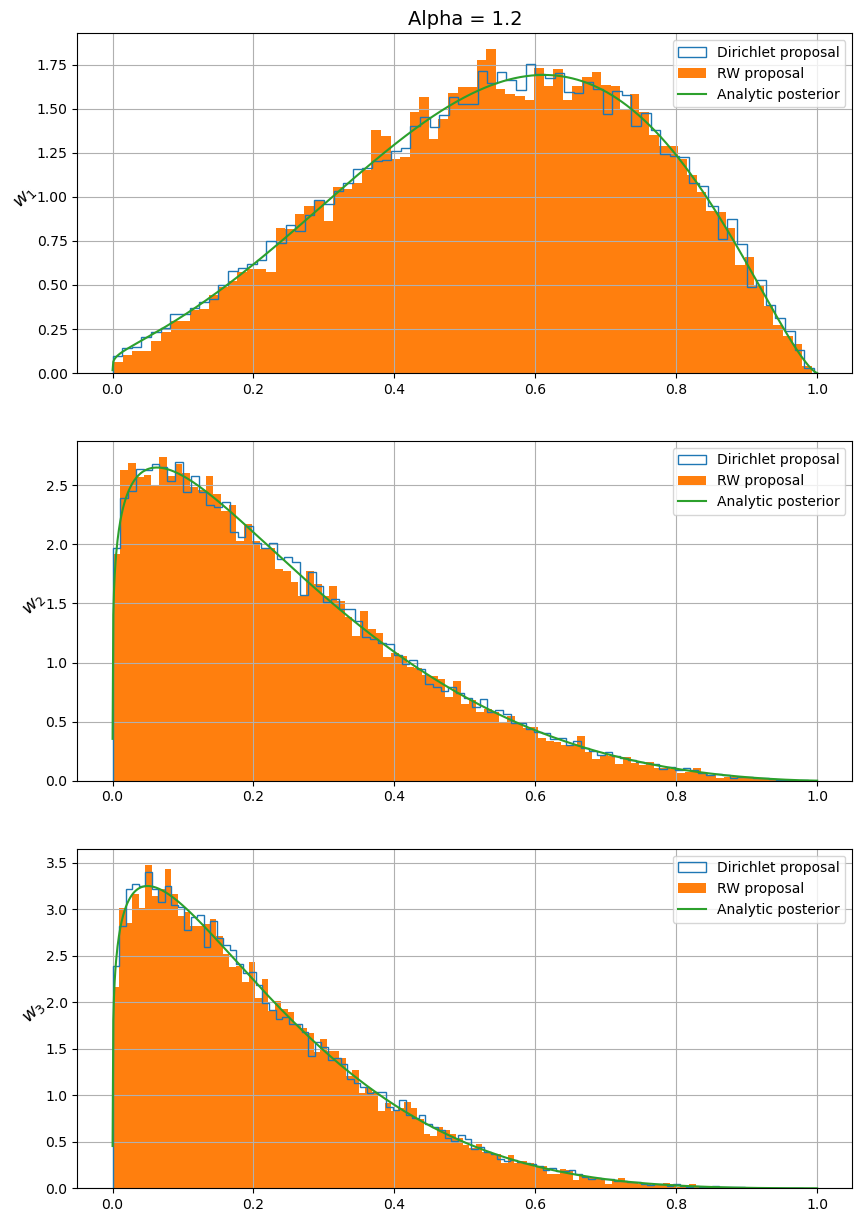

Acceptance rate 0.298319:   0%|          | 132/100000 [00:00<01:15, 1319.01it/s]

[0.97737038 0.35777653 4.65210085]


Acceptance rate 0.310645:  10%|█         | 10190/100000 [00:07<01:09, 1300.39it/s]

[1.08889515e-03 3.15978996e-04 2.13561682e-05]


Acceptance rate 0.311165:  20%|██        | 20210/100000 [00:15<01:02, 1280.90it/s]

[4.60820540e-04 8.94478846e-05 2.55065475e-05]


Acceptance rate 0.313246:  30%|███       | 30129/100000 [00:23<00:55, 1266.45it/s]

[6.63280837e-14 6.55177848e-14 3.72670573e-14]


Acceptance rate 0.314091:  40%|████      | 40159/100000 [00:31<00:46, 1288.87it/s]

[1.93843317e-08 3.01508789e-08 4.03078824e-08]


Acceptance rate 0.312165:  50%|█████     | 50194/100000 [00:39<00:38, 1306.44it/s]

[4.47136080e-13 1.89145150e-15 1.49151707e-13]


Acceptance rate 0.312642:  60%|██████    | 60176/100000 [00:47<00:31, 1262.72it/s]

[1.23223567e-14 8.09896791e-15 7.69112828e-15]


Acceptance rate 0.312770:  70%|███████   | 70113/100000 [00:54<00:22, 1343.77it/s]

[7.55251101e-11 7.77769108e-12 2.47546440e-10]


Acceptance rate 0.312308:  80%|████████  | 80179/100000 [01:02<00:15, 1284.41it/s]

[4.57481245e-10 8.80227154e-11 1.38508500e-10]


Acceptance rate 0.312731:  90%|█████████ | 90207/100000 [01:10<00:07, 1268.67it/s]

[2.73679881e-12 4.90373577e-14 3.89448333e-13]


100%|██████████| 100/100 [00:00<00:00, 588.20it/s]


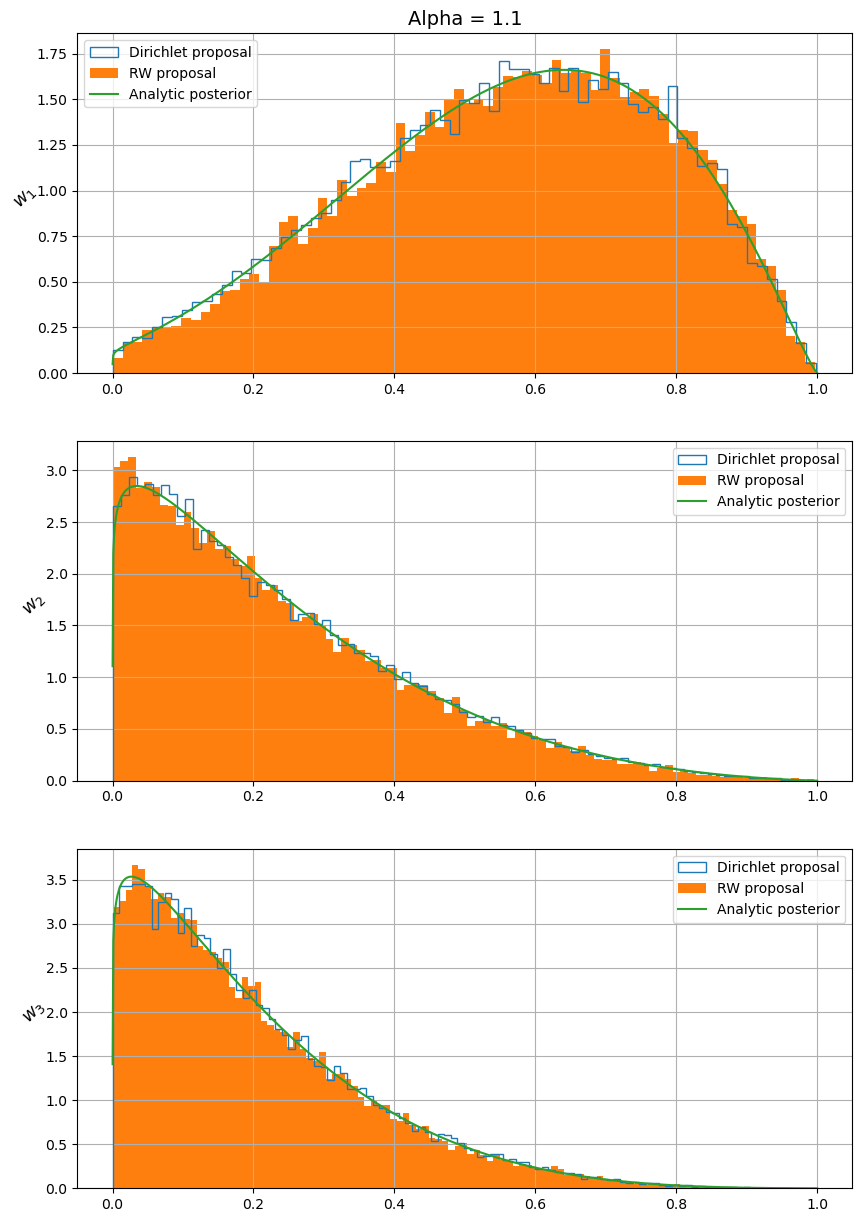

Acceptance rate 0.237500:   0%|          | 129/100000 [00:00<01:17, 1283.50it/s]

[1.73101331 7.40415002 2.49015816]


Acceptance rate 0.323328:  10%|█         | 10215/100000 [00:07<01:08, 1309.24it/s]

[8.09757695e-10 1.38220070e-10 1.05600579e-10]


Acceptance rate 0.324254:  20%|██        | 20164/100000 [00:15<01:00, 1321.98it/s]

[0.00119424 0.00014461 0.00150731]


Acceptance rate 0.322096:  30%|███       | 30225/100000 [00:23<00:53, 1305.80it/s]

[5.37615035e-14 1.68088370e-13 3.07799765e-15]


Acceptance rate 0.321429:  40%|████      | 40173/100000 [00:30<00:45, 1322.28it/s]

[3.05721650e-06 2.95289973e-04 1.24492968e-04]


Acceptance rate 0.322190:  50%|█████     | 50184/100000 [00:38<00:39, 1276.81it/s]

[1.88469428e-23 3.08873343e-23 1.24681738e-23]


Acceptance rate 0.321903:  60%|██████    | 60189/100000 [00:46<00:30, 1288.50it/s]

[5.24041346e-25 2.00150705e-25 1.00765648e-26]


Acceptance rate 0.321493:  70%|███████   | 70179/100000 [00:53<00:22, 1319.68it/s]

[1.23869288e-07 5.52702524e-09 2.83613006e-09]


Acceptance rate 0.322388:  80%|████████  | 80189/100000 [01:01<00:15, 1267.89it/s]

[3.18877055e-24 6.66254560e-24 6.85081657e-25]


Acceptance rate 0.321606:  90%|█████████ | 90144/100000 [01:09<00:07, 1315.51it/s]

[8.03135517e-21 3.25860335e-23 4.63245678e-22]


100%|██████████| 100/100 [00:00<00:00, 619.18it/s]


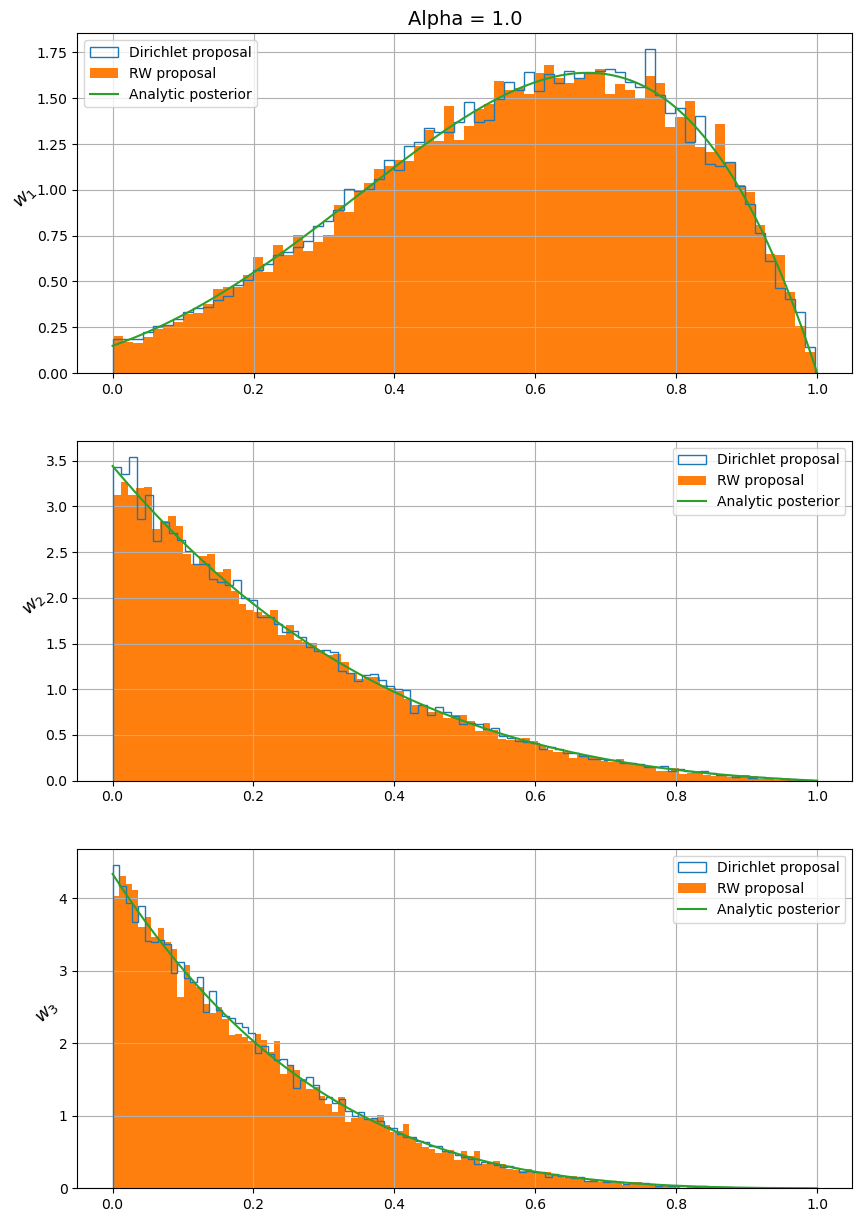

Acceptance rate 0.336134:   0%|          | 134/100000 [00:00<01:14, 1333.25it/s]

[ 2.02583224 10.98730903  1.51231496]


Acceptance rate 0.317817:  10%|█         | 10187/100000 [00:08<01:10, 1279.20it/s]

[0.20792596 0.01995113 0.09781268]


Acceptance rate 0.324978:  20%|██        | 20123/100000 [00:15<01:03, 1266.55it/s]

[1.61755700e-04 1.12134936e-05 2.68637854e-04]


Acceptance rate 0.324953:  30%|███       | 30158/100000 [00:23<00:54, 1271.68it/s]

[1.85080480e-11 3.22521289e-11 7.69735854e-11]


Acceptance rate 0.326341:  40%|████      | 40189/100000 [00:31<00:46, 1277.57it/s]

[2.07192120e-13 1.37843325e-13 2.21433344e-14]


Acceptance rate 0.326465:  50%|█████     | 50221/100000 [00:39<00:39, 1270.30it/s]

[1.35074869e-24 1.68443802e-26 3.90655964e-26]


Acceptance rate 0.327937:  60%|██████    | 60134/100000 [00:47<00:30, 1286.81it/s]

[5.34879698e-14 6.69874954e-15 3.93347076e-14]


Acceptance rate 0.326386:  70%|███████   | 70134/100000 [00:55<00:22, 1309.81it/s]

[1.36310609e-22 6.62981164e-23 1.71551280e-23]


Acceptance rate 0.326765:  80%|████████  | 80113/100000 [01:02<00:15, 1312.52it/s]

[5.18574232e-22 6.41305932e-22 1.81595063e-23]


Acceptance rate 0.327877:  90%|█████████ | 90124/100000 [01:10<00:07, 1271.17it/s]

[8.40487220e-09 2.66947947e-10 1.77313025e-10]


100%|██████████| 100/100 [00:00<00:00, 597.36it/s]


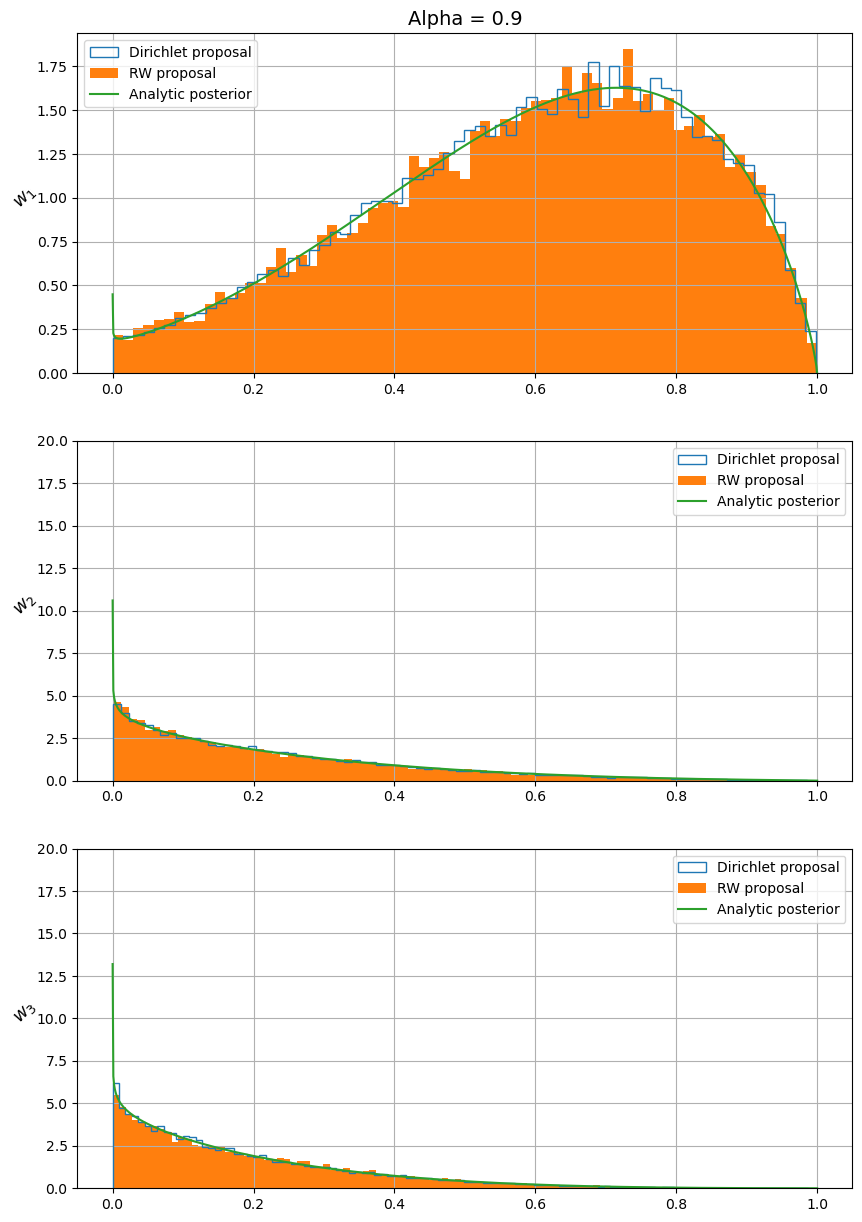

Acceptance rate 0.262712:   0%|          | 131/100000 [00:00<01:16, 1306.46it/s]

[1.77687478 8.40064357 9.91342899]


Acceptance rate 0.331966:  10%|█         | 10177/100000 [00:07<01:09, 1301.28it/s]

[7.99342308e-04 2.52803298e-04 3.87742270e-05]


Acceptance rate 0.334124:  20%|██        | 20185/100000 [00:15<00:59, 1347.55it/s]

[8.34288484e-15 6.99243970e-16 1.11227634e-14]


Acceptance rate 0.331017:  30%|███       | 30124/100000 [00:23<00:53, 1299.12it/s]

[2.23850371e-10 1.87109960e-11 2.63451628e-13]


Acceptance rate 0.330002:  40%|████      | 40170/100000 [00:31<00:46, 1287.87it/s]

[8.37240225e-11 4.71786617e-11 3.55944898e-11]


Acceptance rate 0.330672:  50%|█████     | 50137/100000 [00:39<00:40, 1230.57it/s]

[2.23063563e-12 9.44470564e-15 4.65147346e-13]


Acceptance rate 0.332603:  60%|██████    | 60189/100000 [00:47<00:31, 1272.35it/s]

[0.01581374 0.00128744 0.00686616]


Acceptance rate 0.332882:  70%|███████   | 70212/100000 [00:54<00:23, 1263.19it/s]

[0.02788667 0.00127304 0.00014543]


Acceptance rate 0.332918:  80%|████████  | 80171/100000 [01:02<00:15, 1287.01it/s]

[3.62040992e-15 2.22529720e-13 5.78345817e-15]


Acceptance rate 0.333814:  90%|█████████ | 90175/100000 [01:10<00:07, 1285.46it/s]

[1.07381642e-22 4.61095888e-24 4.96024172e-23]


100%|██████████| 100/100 [00:00<00:00, 617.24it/s]


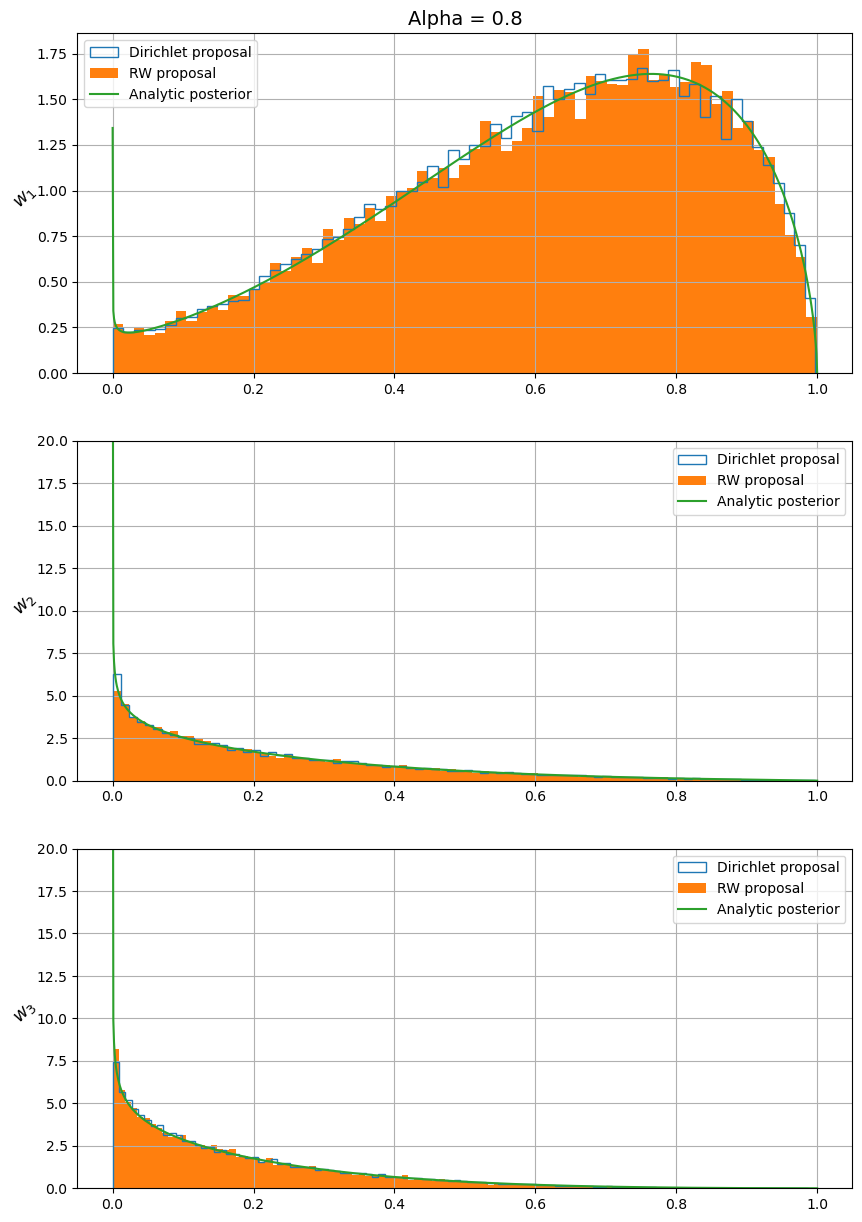

Acceptance rate 0.337449:   0%|          | 133/100000 [00:00<01:15, 1329.71it/s]

[8.64413365 0.06762749 0.52937332]


Acceptance rate 0.345481:  10%|█         | 10154/100000 [00:08<01:09, 1286.39it/s]

[6.22148494e-05 1.11351287e-07 9.66918127e-06]


Acceptance rate 0.345201:  20%|██        | 20163/100000 [00:15<01:01, 1291.15it/s]

[5.88562862e-11 5.99141927e-14 4.32498125e-13]


Acceptance rate 0.346616:  30%|███       | 30193/100000 [00:23<00:54, 1282.52it/s]

[0.03510285 0.00345227 0.00103646]


Acceptance rate 0.346564:  40%|████      | 40218/100000 [00:31<00:47, 1269.61it/s]

[6.23066713e-16 1.43928996e-16 1.53620268e-15]


Acceptance rate 0.345974:  50%|█████     | 50119/100000 [00:39<00:39, 1269.70it/s]

[8.06307704e-10 6.39720475e-09 3.60955022e-10]


Acceptance rate 0.344558:  60%|██████    | 60175/100000 [00:47<00:31, 1256.62it/s]

[1.32220093e-08 1.33292285e-09 1.70762895e-07]


Acceptance rate 0.344445:  70%|███████   | 70142/100000 [00:55<00:23, 1286.96it/s]

[1.70060102e-18 1.66875036e-19 4.56827565e-19]


Acceptance rate 0.345652:  80%|████████  | 80122/100000 [01:02<00:15, 1310.64it/s]

[3.23715957e-21 1.43114662e-21 3.47273942e-22]


Acceptance rate 0.346103:  90%|█████████ | 90144/100000 [01:10<00:07, 1280.03it/s]

[1.70671250e-28 7.19241111e-31 1.41968438e-29]


100%|██████████| 100/100 [00:00<00:00, 611.43it/s]


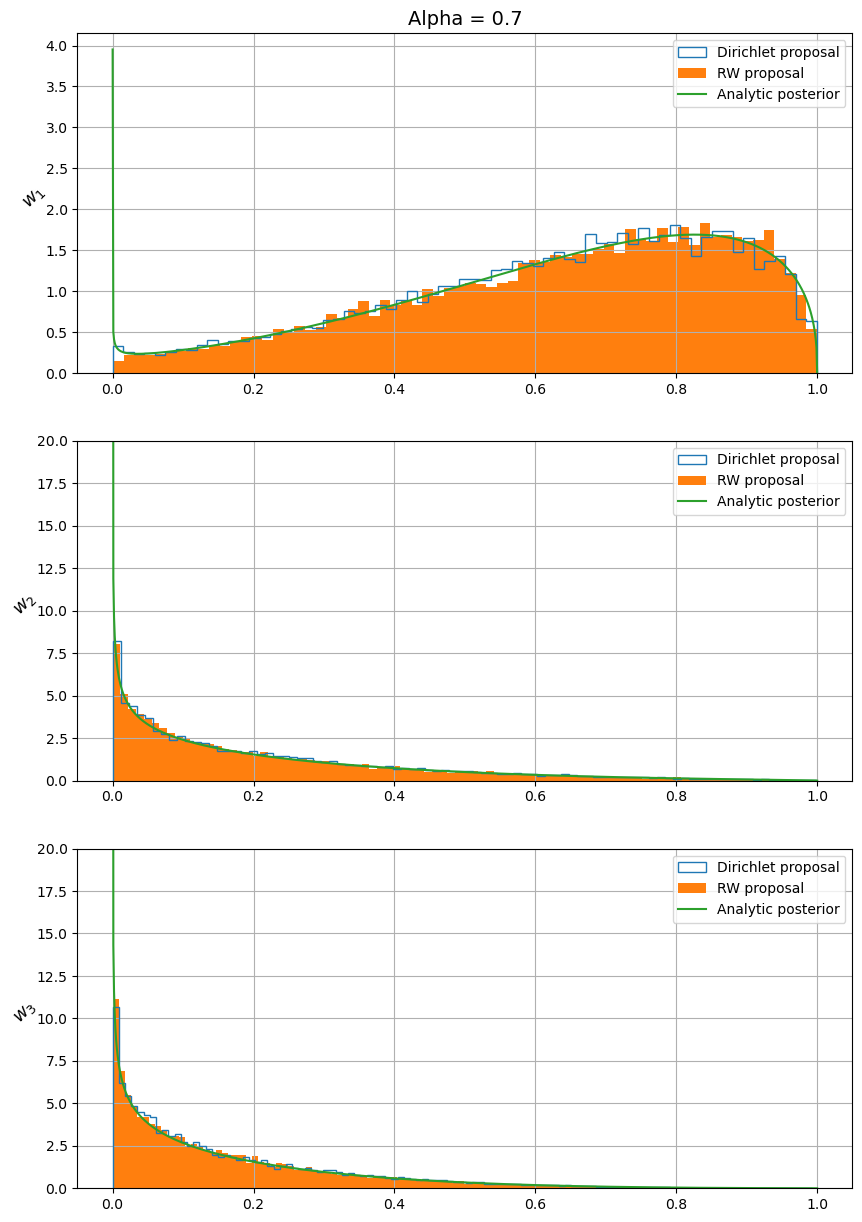

Acceptance rate 0.307018:   0%|          | 136/100000 [00:00<01:13, 1353.14it/s]

[1.82395833 3.09320507 0.87795969]


Acceptance rate 0.364498:  10%|█         | 10225/100000 [00:07<01:11, 1257.24it/s]

[7.01802809e-32 9.28342673e-33 1.36387761e-31]


Acceptance rate 0.358068:  20%|██        | 20102/100000 [00:15<01:02, 1277.87it/s]

[2.52604769e-45 3.80799439e-45 3.35459460e-47]


Acceptance rate 0.354871:  30%|███       | 30235/100000 [00:23<00:52, 1328.13it/s]

[2.71299320e-58 9.84093799e-60 1.84578756e-58]


Acceptance rate 0.354831:  40%|████      | 40235/100000 [00:31<00:46, 1277.90it/s]

[1.12690170e-50 6.10352341e-52 1.47801613e-50]


Acceptance rate 0.355806:  50%|█████     | 50189/100000 [00:39<00:39, 1254.59it/s]

[4.48138014e-50 8.96338947e-52 7.77741625e-53]


Acceptance rate 0.354595:  60%|██████    | 60167/100000 [00:46<00:31, 1278.53it/s]

[1.41745416e-38 8.10592238e-38 1.87127656e-37]


Acceptance rate 0.356394:  70%|███████   | 70149/100000 [00:54<00:23, 1288.13it/s]

[3.72763724e-27 5.40663892e-27 2.65931868e-28]


Acceptance rate 0.356926:  80%|████████  | 80174/100000 [01:02<00:15, 1286.99it/s]

[1.02163336e-37 7.14845378e-37 1.33239708e-38]


Acceptance rate 0.357604:  90%|█████████ | 90191/100000 [01:10<00:07, 1308.82it/s]

[4.10116325e-29 3.38113638e-29 3.88945299e-29]


100%|██████████| 100/100 [00:00<00:00, 613.47it/s]


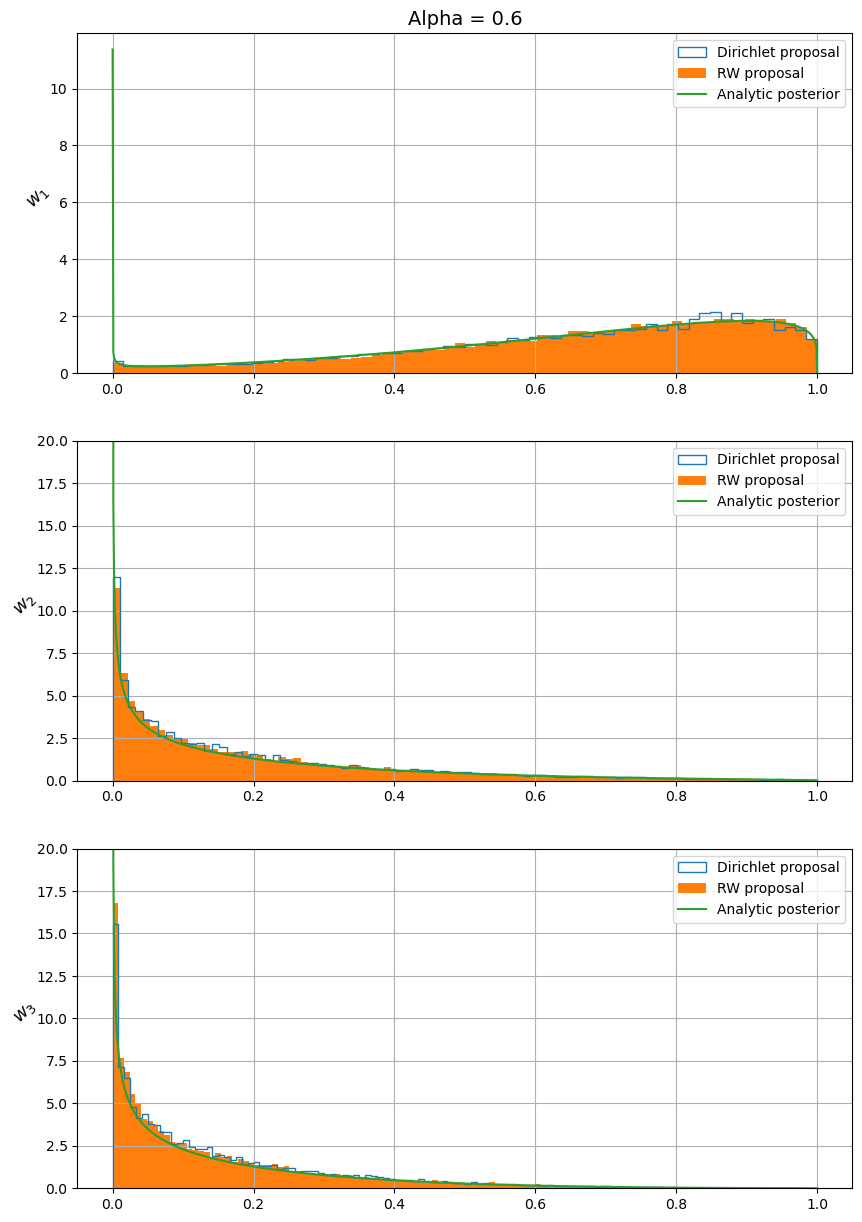

In [7]:

for a in [3,2,1.7,1.5,1.4,1.3,1.2,1.1,1.0,0.9,0.8, 0.7, 0.6]:
    alpha = np.ones(n_pars)*a
    samples = sampling(n, xt, alpha, alpha_prop)
    eps = 1
    each = int(1e4)
    samples2 = sampling2(n, xt, alpha, eps, each)

    anal_x = []
    anal = []
    for i in range(n_pars):
        x,y = an_post(i, 100, xt, alpha)
        anal_x.append(x)
        anal.append(y)

    fig, axs = plt.subplots( n_pars, figsize = [10,15] )
    w = samples
    w2 = samples2
    x = np.arange(0, len(w[0]))
    for i in range(n_pars):
        axs[i].hist(np.transpose(w)[i], bins = 'auto', histtype='step', density = True, label = 'Dirichlet proposal')
        axs[i].hist(np.transpose(w2)[i], bins = 'auto', density = True, label = 'RW proposal')
        axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
        #axs[i].plot(anal_x[i], anal[i], label = 'Numerical posterior')
        if i == 0 : 
            xx = np.linspace(1e-6,1,1000)
            axs[i].plot(xx, w1_post(xx, alpha, xt), label = 'Analytic posterior')
        if i == 1 : 
            xx = np.linspace(1e-6,1,1000)
            axs[i].plot(xx, w2_post(xx, alpha, xt), label = 'Analytic posterior')
        if i == 2 : 
            xx = np.linspace(1e-6,1,1000)
            axs[i].plot(xx, w3_post(xx, alpha, xt), label = 'Analytic posterior')
        axs[i].grid()
        axs[i].legend()
        if a < 1:
            if i > 0 : axs[i].set_ylim([0,20])
    axs[0].set_title(f'Alpha = {alpha[0]}', size = 14)
    plt.savefig('Alpha'+str(alpha[0])+'_second.png')
    plt.show()
    plt.close()

